In [112]:
#!/usr/bin/python
# updated DBR 01/2024 #

%matplotlib inline  

import os

import numpy as np
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['font.family'] = 'Myriad Pro'  # Choose the desired font family (e.g., 'serif', 'sans-serif', 'monospace')
matplotlib.rcParams['font.size'] = 10  # Choose the desired font size


import matplotlib.colors as mcolors
import matplotlib.cm as cm
import pandas as pd
import time
import scipy.stats as st

#ipython magic to make module autoreload
%load_ext autoreload
%autoreload 2

import seaborn as sns
sns.set_style("ticks")

#pull in the code to do the sims!
#import ra_module
#import clones1126 as clmod

import resource
resource.setrlimit(resource.RLIMIT_NOFILE, (1000,-1)) #allow many plots

colormap=cm.jet

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#read in ecology from past work for comparisons
outdf=pd.read_csv('../ecometrics_wprovirusrecalc.csv') #for comparing TCRs among different cohorts


In [3]:
#copied from clmod so it's all just here together

#function that solves stochastically using tau-leap method
def sim_clones(model0, T0, T0_model_param, rate_model, rate_model_param, net_clearance_rate, avg_pro_rate, avg_emerge_rate, t_redraw, dt, tF):
    
    sim_size0, clone_dist0 = make_initial_clones(model0, T0, T0_model_param) #use function to initialize the distribution
    
    xt=clone_dist0; xl=[]; tl=[]
    t=0
            
    #make the initial rate vectors
    proli_rate_vector, death_rate_vector = make_vectors(
                rate_model, sim_size0, rate_model_param, net_clearance_rate, avg_pro_rate, avg_emerge_rate/T0)

    ir=1 #index for updating rates
    
    #loop over entire time 
    while t<tF:
        xl.append(xt); tl.append(t); #add states to list

        #reset the proliferation rate vectors every t_newrates days
        #next step is to include adjacency matrix so some clones are connected??
        if t > t_redraw*ir:
            proli_rate_vector, death_rate_vector = make_vectors(
                    rate_model, len(xt), rate_model_param, net_clearance_rate, avg_pro_rate, avg_emerge_rate/T0)
            ir+=1
        
        prolis=np.random.poisson(proli_rate_vector*xt*dt) #calculate proliferation events for the ith type
        deaths=np.random.poisson(death_rate_vector*xt*dt) #calculate death events for the ith type
        xt=xt+prolis-deaths #compute all updated states
        xt[xt<0]=0 #make sure no negative numbers
        t=t+dt #update time

        #totally new diversity, new clones
        #this shouldn't contribute to existing clones... but maybe its negligible
        births=np.random.poisson(avg_emerge_rate*dt) #calculate birth events for the ith type
        xt=np.append(xt,np.ones(births))
        
        emerge_proli_vector,emerge_death_vector=make_vectors(
                rate_model, births, rate_model_param, net_clearance_rate, avg_pro_rate, avg_emerge_rate/T0) #new rates for new clones
        
        proli_rate_vector=np.append(proli_rate_vector, emerge_proli_vector) #add on new vector   
        death_rate_vector=np.append(death_rate_vector, emerge_death_vector) #add on new vector   

    #postprocess sim_clones to make it an array
    Lf=len(xt) #the max length is that of the last time point
    ci_t=np.zeros([Lf,len(tl)])
    for i in range(len(tl)):
        ci_t[:len(xl[i]),i]=xl[i]

    return np.array(tl), ci_t
    
#initialize the clone distribution
def make_initial_clones(model0, T0, T0_model_param):
    
    #make initial clone sizes
    if model0=='const':
        clone_dist0=np.ones(int(T0/T0_model_param))*T0_model_param #uniform, all = parameter

    #make initial clone sizes
    if model0=='uni':
        clone_dist0=np.random.uniform(1,T0_model_param,[int(T0/T0_model_param)]) #uniform, all between 1 and rate param

    if model0=='exp':
        random_draws = np.random.exponential(T0_model_param,[T0])        
        clone_dist0=np.round(T0*random_draws/np.sum(random_draws))
        clone_dist0=clone_dist0[clone_dist0>0]

    if model0=='pwl':
        #random_draws = np.random.pareto(T0_model_param,[T0])
        #clone_dist0=np.round(T0*random_draws/np.sum(random_draws)) #power law-ish
        #clone_dist0=clone_dist0[clone_dist0>0]
        #sim_size0=len(clone_dist0)
        
        r=np.arange(1,T0)
        pa=r**-T0_model_param
        pa=pa/np.sum(pa)
        clone_dist0=np.random.multinomial(n=T0,pvals=pa,size=1)[0]
        clone_dist0=clone_dist0[clone_dist0>0]

    if model0=='pwl2':
        r=np.arange(1,T0)
        pa=r**-T0_model_param[0]+T0_model_param[2]*r**-T0_model_param[1]
        pa=pa/np.sum(pa)
        clone_dist0=np.random.multinomial(n=T0,pvals=pa,size=1)[0]
        clone_dist0=clone_dist0[clone_dist0>0]
        
    return len(clone_dist0), clone_dist0
    
#make rate arrays given the type of proliferation
def make_vectors(rate_model, sim_size, rate_model_param, net_clearance_rate, avg_pro_rate, avg_emerge_rate_T0scaled):
    
    #all proliferate the same
    if rate_model=='const':
        proli_rate_vector=np.ones(sim_size)*avg_pro_rate

    #all proliferate from uniform 
    if rate_model=='uni':
        proli_rate_vector=np.random.uniform(0,1,[sim_size])*avg_pro_rate

    #uneven proliferation (exponential)
    elif rate_model=='exp':
        proli_rate_vector=np.random.exponential(rate_model_param,[sim_size])*avg_pro_rate

    #uneven proliferation (powerlaw)
    elif rate_model=='pwl':
        proli_rate_vector=np.random.pareto(rate_model_param,[sim_size])*avg_pro_rate

    #2 types of proliferation, both constant, but with different rates
    elif rate_model=='2const':
        n1=int(sim_size*rate_model_param[0]) #number in first phase -- larger clones
        n2=sim_size-n1
        proli_rate_vector=np.append(np.ones(n1)*avg_pro_rate[0],np.ones(n2)*avg_pro_rate[1])

    #2 types of proliferation, both follow exponential, but with different rates
    elif rate_model=='2exp':
        n1=int(sim_size*rate_model_param[0]) #number in first phase -- larger clones
        n2=sim_size-n1
        proli_rate_vector=np.append(np.random.exponential(rate_model_param[1],[n1])*avg_pro_rate[0],
                                    np.random.exponential(rate_model_param[2],[n2])*avg_pro_rate[1])
        
    death_rate_vector=proli_rate_vector - np.ones(sim_size)*(net_clearance_rate - avg_emerge_rate_T0scaled) #enforce balance of birth and death on clone level
        
    return  proli_rate_vector, death_rate_vector
    
#function to resample and compute R D1 and D2
def compute_ecology(unsorted_abunds,sample_size):

    pa=unsorted_abunds/np.sum(unsorted_abunds)
    
    rs = np.random.multinomial(n=sample_size,pvals=pa) #resampled abundance

    #calculate ecology and add to lists
    TCR=rs[rs>0]
    R=len(TCR);  
    r=np.arange(R)+1
    a=-np.sort(-TCR)
    pars=a/np.sum(a)
    cpa=np.cumsum(pars)
    D1=np.exp(-np.sum(pars*np.log(pars)))
    D2=1/np.sum(pars**2)
    
    return r,pars,a,R,D1,D2


In [455]:
#### fixed parameters across all models

tF=365*10 #9 years
dt=30 #monthly

sample_times=[10,25,90] #essentially in months (given dt)
c3=['tab:blue','tab:green','tab:red'] #colors for samples

ss=1e4; HIVss=100 #sample sizes

T0=int(1e6) #initial size of population, needs to be an integer
Trescale= T0/800 #to get ~800 per µL

cHIV = 3000*T0/1e6; cHIVint = 800*T0/1e6; #HIV provirus parameters, from IPDA data, per million CD4

zeta=0.001 #additional advantage, should basically balance out xi
cHIVsurv=300*T0/1e6 #1/100 intact? total? have survival advantages?

####



In [456]:
#change some things and run simulations!

#uniform T0 with T0 model param=100 (T0i), uniform proliferation, no reemergence, never redraw rates, no xi, full coverage
#fn='1'; m0='uni'; Tmp=100; rm='uni'; rmp=0; apr=0.01; ncr=0; aer=0; trd=20000; xi_def=0; xi_int=0; HIVfullycover=True 

#uniform T0 with T0 model param=100 (T0i), uniform proliferation, no reemergence, never redraw rates, no xi, random coverage
#fn='1.1'; m0='uni'; Tmp=100; rm='uni'; rmp=0; apr=0.01; ncr=0; aer=0; trd=20000; xi_def=0; xi_int=0; HIVfullycover=False 

#pwl T0 with T0 model param =0.8 (alpha), uniform proliferation, no reemergence, never redraw rates, no xi, random coverage
#fn='2'; m0='pwl'; Tmp=0.8; rm='uni'; rmp=0; apr=0.01; ncr=0; aer=0; trd=20000; xi_def=0; xi_int=0; HIVfullycover=False 

#pwl T0 with T0 model param =0.8 (alpha), exp proliferation, no reemergence, never redraw rates, no xi, random coverage
#fn='3.1'; m0='pwl'; Tmp=0.8; rm='exp'; rmp=1; apr=0.01; ncr=0; aer=0; trd=20000; xi_def=0; xi_int=0; HIVfullycover=False 
#^this one doesn't really help anything in particular?

#pwl T0 with T0 model param =0.8 (alpha), uni proliferation, no reemergence,  redraw rates every 6mo, no xi, random coverage
#fn='4'; m0='pwl'; Tmp=0.8; rm='uni'; rmp=0; apr=0.01; ncr=0; aer=0; trd=100; xi_def=0; xi_int=0; HIVfullycover=False 

#pwl T0 with T0 model param =0.8 (alpha), uni proliferation, no reemergence,  redraw rates every 6mo, 30mo hl for intact, random coverage
#fn='5'; m0='pwl'; Tmp=0.8; rm='uni'; rmp=0; apr=0.01; ncr=0; aer=0; trd=100; xi_def=np.log(2)/(161*30); xi_int=np.log(2)/(32*30); HIVfullycover=False 

#pwl T0 with T0 model param =0.8 (alpha), exp proliferation, no reemergence,  redraw rates every 6mo, 30mo hl for intact, random coverage
#fn='6'; m0='pwl'; Tmp=0.8; rm='exp'; rmp=1; apr=0.01; ncr=0; aer=0; trd=100; 
#xi_def=np.log(2)/(98*365/12) #defective,with half life in months, converted to rate per day
#xi_int=np.log(2)/(35*365/12) #intact
#HIVfullycover=False 

#pwl T0 with T0 model param =0.8 (alpha), exp proliferation, no reemergence,  redraw rates every 6mo, 30mo hl for intact, random coverage
fn='7'; m0='pwl'; Tmp=0.8; rm='exp'; rmp=1; apr=0.01; ncr=0; aer=0; trd=100; 
xi_def=np.log(2)/(98*365/12) #defective,with half life in months, converted to rate per day
xi_int=np.log(2)/(35*365/12) #intact
HIVfullycover=False 

#use module to do the simulation
t,T = sim_clones(
        model0=m0,                 #type of initial condition distribution ['const','uni','exp','pwl']
        T0=T0,                        #initial number of T cells in simulation
        T0_model_param=Tmp,       #parameterize initial size distribution ['const','uni','exp','pwl']
        rate_model=rm,             #model for proliferation events, options: ['uni','exp','pwl','2phase']
        rate_model_param=rmp,           #parameterize distribution of proliferation rates disrtribution (a list if 2phase is chosen)
        net_clearance_rate=ncr,         #balance for T cells, net = prolif - death
        avg_pro_rate=apr,       #per day, TCM rate
        avg_emerge_rate=aer,    #cells/day, new
        t_redraw=trd,           #how often to redraw T cell proliferation rates, pick large to prevent
        dt=dt,                  #time step
        tF=tF                   #simulation days
)


In [457]:
#make full copy of TCR big list, just zero out indices without HIV

H=np.zeros_like(T) #abudance array
fH = np.zeros(len(T)) #fraction array

#or have another list that just says for each TCR index is it type: 1,2,3,4
#where index tells you if has HIV, intact, survival
#that's getting to be like object oriented!

In [458]:
print(len(H),len(T))

390938 390938


In [459]:
np.shape(T)

(390938, 122)

In [460]:
#do simulation of HIV clones/proviruses among TCR

iTCRl=[]; iTCRlint=[]; iTCRlsurv=[] #indices for various types of clones

c=0
while c<cHIV: #with a little wiggle room?

    iTCR=np.random.randint(len(T)) #pick random one
    iTCRl.append(iTCR) #add it to list

    TCRclonesize=T[iTCR,0] #get that TCR clone size

    #pick the % of cells in taht TCR clone that are HIV infected (can start with all)?
    if HIVfullycover:
        HIVc = TCRclonesize
    else:#elif HIVuniformcover:
        HIVc = np.random.randint(0,TCRclonesize)
    #elif HIVproportionalcover:
    #    HIVc = np.random.poisson(cHIV*TCRclonesize/T0)

    fH[iTCR] = HIVc/TCRclonesize #should be 1 unless not fully covered
    H[iTCR,0] = HIVc
    
    c += HIVc #update total count

    #note which one ares intact
    if np.random.rand()<cHIVint/cHIV:
        iTCRlint.append(iTCR)
        
    #note which one have survival advantages, don't have to be intact, but note can be
    if np.random.rand()<cHIVsurv/cHIV:
        iTCRlsurv.append(iTCR)

#now do calculation over time for proviruses
#for now assume HIV stays constant fraction -- if decays extra that just gets added additionally

#basically now H = POIS(fH*T_t*exp(-xi*t))
#we solve dT/dt = (a-d)T for T(t) stochastically
#then we had dH/dt = (a-d-r+s)H = (a-d)H+(-r+s)H
#so then mean solution is H = H0*exp((a-d)t)*exp((-r+s)t)
#and we instead use first term as from T cells: H = fH(0)*T(t)*exp((-r+s)*t)

#T = T + H
#fH = H/T
#H = fH*T*exp(t)

#so then loop through and make sure exponent is correct for the H term
thi=0
for i in iTCRl:
    thi=-xi_def #everyone gets this
    if i in iTCRlint:
        thi=thi - (xi_int-xi_def) #shouldn't also have defective
    if i in iTCRlsurv:
        thi=thi+zeta
    #H[i,:]=np.round(fH[i]*T[i,:]*np.exp(thi*t))
    H[i,:]=np.random.poisson(fH[i]*T[i,:]*np.exp(thi*t))

H[H<0]=0 #??

In [461]:
#deal with HIV clones changing numbers of T cells??
for i in range(len(T)):
    T[i,:]=T[i,:] + H[i,:]
    #T[i,:]=T[i,:] + H[i,0] - H[i,:]

T[T<0]=0 #is this safe??


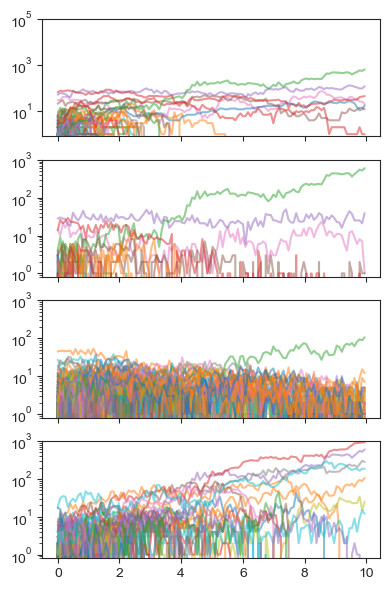

In [462]:
#examples of clone traces

fig,axs=plt.subplots(4,1,sharex=True,sharey=False,figsize=(4,6),)

num_examples=100
#num_examples=len(iTCRlint)

tplot=t/365 #years!

for j in range(num_examples):
    axs[0].semilogy(tplot,T[iTCRl[j],:],alpha=0.5)   
    axs[1].semilogy(tplot,H[iTCRl[j],:],alpha=0.5)   

for j in range(len(iTCRlint)):
    axs[2].semilogy(tplot,H[iTCRlint[j]],alpha=0.5)   

for j in range(len(iTCRlsurv)):
    axs[3].semilogy(tplot,H[iTCRlsurv[j]],alpha=0.5)   

#axs[0].set_ylabel('TCRβ')
#axs[0].set_title('Individual clones')
#axs[1].set_ylabel('HIV DNA')
#axs[2].set_ylabel('Intact \n HIV DNA')
#axs[2].set_xlabel('Simulated months')

axs[0].set_ylim([0.8,1e5])
axs[1].set_ylim([0.8,1e3])
axs[2].set_ylim([0.8,1e3])
axs[3].set_ylim([0.8,1e3])

plt.tight_layout()
plt.subplots_adjust(hspace = 0.2)
plt.subplots_adjust(wspace = 0.2)

plt.savefig('figures/'+fn+'-traces.pdf')


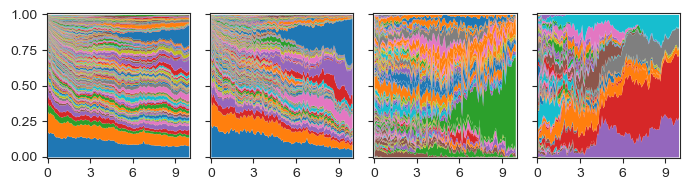

In [463]:
fig,axs=plt.subplots(1,4,sharex=True,sharey=True,figsize=(7,2))

yT=T[H[:,30]>0,:]
axs[0].stackplot(tplot,yT/np.sum(yT,axis=0),lw=0)

yT=H[H[:,30]>0,:]
axs[1].stackplot(tplot,yT/np.sum(yT,axis=0),lw=0)

yT=H[iTCRlint,:]
axs[2].stackplot(tplot,yT/np.sum(yT,axis=0),lw=0.0)

yT=H[iTCRlsurv,:]
axs[3].stackplot(tplot,yT/np.sum(yT,axis=0),lw=0.0)

axs[0].set_xlim(-0.05,tF/365+0.05)
axs[0].set_ylim(-0.01,1.01)

plt.xticks(np.arange(0,tF/365+1,3))

plt.tight_layout()
plt.savefig('figures/'+fn+'-tracesprop.pdf')


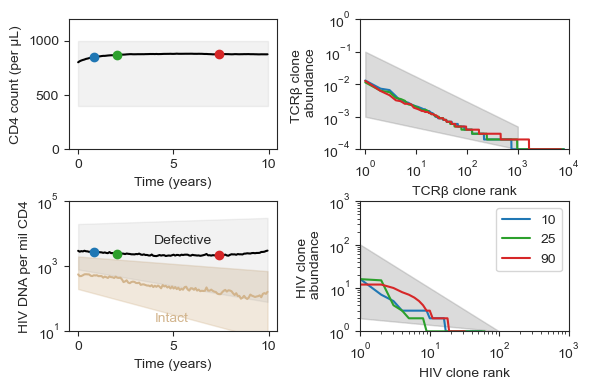

In [464]:
#rank abundance plots

plt.figure(figsize=(6,4))

az=0.1

#total TCR
plt.subplot(221)
plt.plot(tplot,np.sum(T,axis=0)/Trescale,color='k') #
plt.fill_between(tplot,400*np.ones(len(t)),1000*np.ones(len(t)),color='gray',alpha=az)

Dl=[] #list for Hill exponents
for i,iit in enumerate(sample_times):
    
    plt.subplot(221)    
    plt.plot(tplot[iit],np.nansum(T[:,iit])/Trescale,marker='o',ls='',markersize=6,color=c3[i])
    plt.xlabel('Time (years)')
    plt.ylabel('CD4 count (per µL)')  
    plt.ylim([0,1200])

    #rank abundnace for TCR
    r,pars,a,RN,D1,D2 = compute_ecology(unsorted_abunds=T[:,iit],sample_size=ss)
    Dl.append([RN,D1,D2])
    
    plt.subplot(222)
    plt.loglog(r,pars,label=iit,color=c3[i])
    plt.xlabel('TCRβ clone rank')
    plt.yticks(np.logspace(-4,0,5))
    plt.xticks([1,10,100,1e3,1e4])
    plt.ylabel('TCRβ clone \n abundance')
    
    #plot comparison data (just use high and low from Fig 1 TCR rank abundances)
    plt.fill_between([1,1e3],[1e-1,5e-4],[1e-3,1e-4],color='gray',alpha=az)
    
#plt.legend()
plt.xlim([0.8,1e4])
plt.ylim([1e-4,1])

#HIV total sizes
plt.subplot(223)
plt.plot(tplot,np.sum(H,axis=0),color='k',label='total')
plt.semilogy(tplot,np.sum(H[iTCRlint],axis=0),color='tan',label='intact')
#plt.semilogy(tplot,np.sum(H[iTCRlsurv],axis=0),color='tab:purple',label='survival',alpha=0.3)

#decay rate bands, needs to be in years (for tplot)
thI1=np.log(2)/(23/12); thI2=np.log(2)/(80/12)
thD1=np.log(2)/(36/12); thD2=-np.log(2)/(190/12)
plt.fill_between(tplot,200*np.exp(-tplot*thI1),2000*np.exp(-tplot*thI2),color='tan',alpha=0.3)
plt.fill_between(tplot,800*np.exp(-tplot*thD1),20000*np.exp(-tplot*thD2),color='gray',alpha=az)

#plt.legend(loc=3)
plt.xlabel('Time (years)')
plt.ylabel('HIV DNA per mil CD4')
plt.ylim([10,1e5])
plt.annotate('Defective',[4,5e3])
plt.annotate('Intact',[4,20],color='tan')

HDl=[]
for i,iit in enumerate(sample_times):
    plt.subplot(223)
    
    plt.plot(tplot[iit],np.sum(H[:,iit],axis=0),marker='o',ls='',color=c3[i],markersize=6)
    r,pars,a,RN,D1,D2 = compute_ecology(unsorted_abunds=H[H[:,iit]>0,iit],sample_size=HIVss)

    HDl.append([RN,D1,D2])

    #HIV model rank abundances
    plt.subplot(224)
    plt.loglog(r,a,label=iit,color=c3[i])
    plt.xlabel('HIV clone rank')
    plt.ylabel('HIV clone \n abundance')
    
    #plot comparison data (just use high and low from Fig 1 TCR rank abundances)
    plt.fill_between([1,100],[100,1],[2,1],color='gray',alpha=az)

plt.xlim([1,1e3])
plt.ylim([1,1e3])
plt.legend()

plt.tight_layout()
plt.subplots_adjust(hspace = 0.4)
plt.subplots_adjust(wspace = 0.4)

plt.savefig('figures/'+fn+'-ras.pdf')


In [465]:
#find some TCR clonotypes that persist at leasst 50mo
#persistentTCR = np.where(T[iTCRl,50]>1)[0]

#find some HIV clonotypes that persist
persistentHIV = np.where(H[:,30]>1)[0]


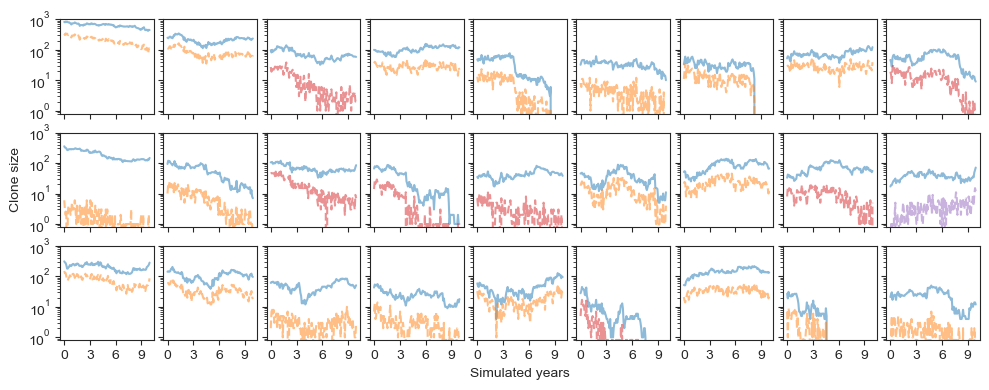

In [466]:
#examples of fractions infected
i=0
nx=3
ny=9
fig,axs=plt.subplots(nx,ny,sharex=True,sharey=True,figsize=(10,4),)
for j in range(ny*nx):
    jj=persistentHIV[j+1]
    
    cz='tab:orange'
    if jj in iTCRlint:
        cz='tab:red'
    if jj in iTCRlsurv:
        cz='tab:purple'
    ax=axs[j%nx][int(j/nx)]
    ax.plot(tplot,T[jj,:],color='tab:blue',alpha=0.5,label='TCRβ')   #the index among TCR
    ax.plot(tplot,H[jj,:],color=cz,alpha=0.5,label='HIV',ls='--')   
    #ax.fill_between(t/30,np.ones(len(t))*0.1,T[iTCRl[jj],:]+0.1,color='tab:blue',alpha=1,label='TCRb')   #the index among TCR
    #ax.fill_between(t/30,np.ones(len(t))*0.1,H[jj,:]+0.1,color='tab:orange',alpha=1,label='HIV')   #the index among TCR

ax.set_ylim([0.8,1e3])
ax.set_xticks(np.arange(0,tF/365+1,3))
axs[1][0].set_ylabel('Clone size')
#axs[0][0].legend()
axs[2][4].set_xlabel('Simulated years')

plt.semilogy()
plt.tight_layout()
plt.subplots_adjust(hspace = .2)
plt.subplots_adjust(wspace = 0.1)

plt.savefig('figures/'+fn+'-bluepurp.pdf')


/var/folders/yk/0drxrmsj07l2thjtfhfyxcxh0000gn/T/ipykernel_718/3841436114.py:5: RuntimeWarning: invalid value encountered in divide
  axs[0].plot(tplot,H[i,:]/T[i,:],color='tab:orange',alpha=0.05)
/var/folders/yk/0drxrmsj07l2thjtfhfyxcxh0000gn/T/ipykernel_718/3841436114.py:7: RuntimeWarning: invalid value encountered in divide
  axs[1].plot(tplot,H[i,:]/T[i,:],color='tab:red',alpha=0.05)
/var/folders/yk/0drxrmsj07l2thjtfhfyxcxh0000gn/T/ipykernel_718/3841436114.py:9: RuntimeWarning: invalid value encountered in divide
  axs[2].plot(tplot,H[i,:]/T[i,:],color='tab:purple',alpha=0.1)


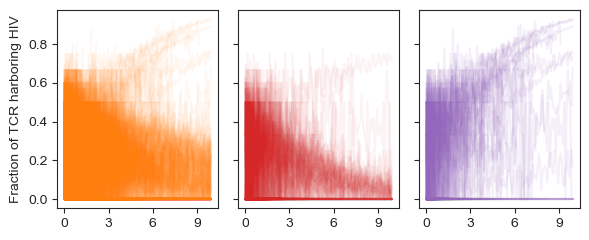

In [467]:
#show coverage fraction by type
fig,axs=plt.subplots(1,3,sharex=True,sharey=True,figsize=(6,2.5))

for i in iTCRl:
    axs[0].plot(tplot,H[i,:]/T[i,:],color='tab:orange',alpha=0.05)
for i in iTCRlint:
    axs[1].plot(tplot,H[i,:]/T[i,:],color='tab:red',alpha=0.05)
for i in iTCRlsurv:
    axs[2].plot(tplot,H[i,:]/T[i,:],color='tab:purple',alpha=0.1)
axs[2].set_xticks(np.arange(0,tF/365+1,3))
axs[0].set_ylabel('Fraction of TCR harboring HIV')

plt.tight_layout()
plt.savefig('figures/'+fn+'-HIVfractions.pdf')


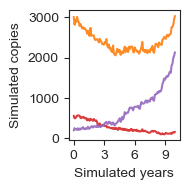

In [468]:
#show coverage fraction by type
plt.figure(figsize=(2,2))
plt.plot(tplot,np.sum(H[iTCRl,:],axis=0),color='tab:orange',alpha=0.9,label='Defective')
plt.plot(tplot,np.sum(H[iTCRlint,:],axis=0),color='tab:red',alpha=0.9,label='Intact')
plt.plot(tplot,np.sum(H[iTCRlsurv,:],axis=0),color='tab:purple',alpha=0.9,label='Survival')
plt.ylabel('Simulated copies')
plt.xlabel('Simulated years')
#plt.legend()
plt.xticks(np.arange(0,tF/365+1,3))
plt.tight_layout()
plt.savefig('figures/'+fn+'-HIVtypes.pdf')


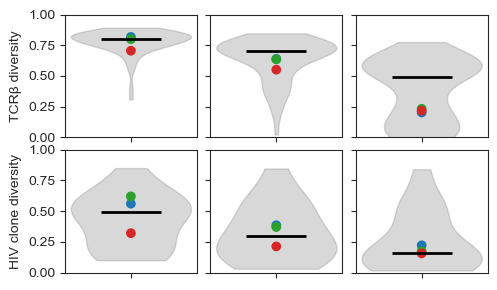

In [470]:
#normalized Hill coefficients, now with violin plots

fig,axs=plt.subplots(2,3,sharex=True,sharey=True,figsize=(5,3))

m3=['o','s','>']
for i in range(3):
    m=['R','D1','D2'][i]

    #TCR metrics
    vps=axs[0][i].violinplot([outdf[m]/ss],positions=[1],widths=0.9,showextrema=False,showmedians=True,)
    # Make the violin body blue with a red border:
    for vp in vps['bodies']:
        vp.set_facecolor('gray')
        vp.set_edgecolor('gray')
        vp.set_linewidth(1)
        vp.set_alpha(0.3)

    vp = vps['cmedians']
    vp.set_edgecolor('k')
    vp.set_linewidth(2)

    axs[0][i].scatter(np.ones(3),np.array(Dl)[:,i]/ss,c=c3)

    
    #HIV metrics
    vps=axs[1][i].violinplot([outdf[m+'HIV'].dropna()/HIVss],positions=[1],widths=0.9,showextrema=False,showmedians=True,)
    # Make the violin body blue with a red border:
    for vp in vps['bodies']:
        vp.set_facecolor('gray')
        vp.set_edgecolor('gray')
        vp.set_linewidth(1)
        vp.set_alpha(0.3)

    vp = vps['cmedians']
    vp.set_edgecolor('k')
    vp.set_linewidth(2)

    axs[1][i].scatter(np.ones(3),np.array(HDl)[:,i]/HIVss,c=c3)#,marker=m3)
    
axs[0][0].set_ylabel('TCRβ diversity')
axs[1][0].set_ylabel('HIV clone diversity')
axs[1][0].set_xticks([1],[])#,['Model (dots) \n vs Experiment (shading)'])

axs[0][0].set_ylim([0,1])
plt.tight_layout()
plt.subplots_adjust(hspace = .1)
plt.subplots_adjust(wspace = .1)
plt.savefig('figures/'+fn+'-sim-ecometrics.pdf')


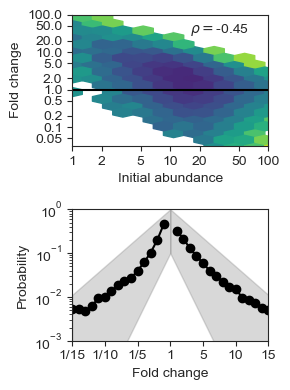

In [471]:
#clone dynamics

#now calculate clone shifts/fold expansions etc to mimic data
t1=sample_times[1]; t2=sample_times[2]
T1=T[:,t1]; T2=T[:,t2]

#drop zeros
T1z = T1[(T1>0) & (T2>0)]
T2z = T2[(T1>0) & (T2>0)]

#size t1 vs change in size
r=st.pearsonr(T1z,T2z-T1z)[0]
ratios=T2z/T1z

expands=ratios[ratios>1]
contracts=ratios[ratios<1]

plt.figure(figsize=(3,4))

plt.subplot(211)
plt.hexbin(np.log10(T1z),np.log10(T2z/T1z),gridsize=20,cmap='viridis_r',mincnt=1,bins='log',vmin=0.5,vmax=3000)
plt.axhline(0,ls='-',color='black')
#plt.xlabel('log10 abundance, t1')
#plt.ylabel('log10 clone change, t1->t2')

plt.xlabel('Initial abundance')
plt.ylabel('Fold change')
plt.yticks(np.log10(np.array([1/100,1/50,1/20,1/10,1/5,1/2,1,2,5,10,20,50,100,200,500,1000])),np.array([1/100,1/50,1/20,1/10,1/5,1/2,1,2,5,10,20,50,100,200,500,1000]))
plt.ylim([-1.5,2])
plt.xticks(np.log10(np.array([1,2,5,10,20,50,100,200,500,1000])),np.array([1,2,5,10,20,50,100,200,500,1000]))
plt.xlim([0,2])
plt.annotate(r'$\rho=$'+str(np.round(st.spearmanr(np.log10(T1z),np.log10(T2z/T1z))[0],2)),[1.2,1.5])

#cbar=plt.colorbar()
#cbar.set_label(r'# clonotypes')
#cbar.set_ticks(np.log10(np.array([1,2,5,10,20,50,100,200,500,1000])))
#cbar.set_ticklabels(np.array([1,2,5,10,20,50,100,200,500,1000]))

#fit the expansion distributions
cz=['tab:purple','tab:green']
plt.subplot(212)
for j in range(2):

    if j==0:
        pdist = expands
        tn='expand'
        binz=np.arange(0,26)+1
        ecs=1
    if j==1:
        pdist = 1/contracts
        tn='contract'
        binz=np.arange(0,26)+1
        ecs=-1

    c,x = np.histogram(pdist,bins=binz,density=True)
    plt.plot(ecs*x[:-1],c,marker='o',ls='-',color='k',label=tn)
    xx=np.linspace(0,15,100)
    plt.fill_between(ecs*xx,0.1*np.exp(-0.7*xx),1*np.exp(-0.3*xx),color='gray',alpha=0.3)
  
    #plt.legend()
    plt.semilogy()
    plt.ylim([1e-3,1])
    plt.ylabel('Probability')
    plt.xlabel('Fold change')
    plt.xticks(np.linspace(-20,20,9),['1/20','1/15','1/10','1/5','1','5','10','15','20'])
    plt.xlim([-15,15])

plt.tight_layout()
plt.savefig('figures/'+fn+'-foldchanges.pdf')


In [472]:
print(xi_def,'per day means % defective clearance due to selection',xi_def/(xi_def+apr)*100)

0.00023253469853842167 per day means % defective clearance due to selection 2.2725033961686547


In [473]:
print(xi_int,'per day means % intact clearance due to selection',xi_int/(xi_int+apr)*100)

0.0006510971559075808 per day means % intact clearance due to selection 6.112958565460581
